In [63]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

load_dotenv()

True

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    route: list[str] | None      
    sql_result: str | None
    vector_result: str | None

In [65]:
# Define Tools
@tool
def run_sql_query(query: str):
    """Run a database query and return the results."""
    if "calls yesterday" in query.lower():
        return "42 calls were made yesterday."
    elif "today" or "current" in query.lower():
        return "17 calls so far today."
    else:
        return "No data found."
    
@tool
def search_vector_db(query: str):
    """Perform a semantic vector search."""
    return f"Search results for '{query}' (vector-based)."

tools = [run_query]

In [66]:
main_llm = ChatOpenAI(model="gpt-4o")
sql_llm = ChatOpenAI(model="gpt-4o-mini")
vect_llm = ChatOpenAI(model="gpt-4o-mini")

In [67]:
def main_agent(state: AgentState) -> AgentState:
    system = SystemMessage(content="""
    You are the main coordinator.
    Decide which agents should run:
    - Use SQL agent for structured or numeric data.
    - Use Vector agent for semantic or fuzzy searches.
    After all routes are done, summarize everything and end.
    """)
    response = main_llm.invoke([system] + state["messages"])
    text = response.content.lower()

    routes = state.get("route")
    if not routes:  # only set routes once
        routes = []
        if "sql" in text or "database" in text or "calls" in text:
            routes.append("sql_agent")
        if "vector" in text or "semantic" in text or "product issue" in text:
            routes.append("vector_agent")

    # Only summarize if routes are empty (last pass)
    if not routes:
        summary_msg = main_llm.invoke([
            SystemMessage(content="Summarize results from all agents."),
        ] + state["messages"])
        return {"messages": state["messages"] + [response, summary_msg], "route": []}

    return {"messages": state["messages"] + [response], "route": routes}

Agents

In [68]:
sql_llm_bound = sql_llm.bind_tools([run_sql_query])

def sql_agent(state: AgentState) -> AgentState:
    system = SystemMessage(content="You are an expert SQL query builder.")
    response = sql_llm_bound.invoke([system] + state["messages"])
    return {"messages": state["messages"] + [response]}

In [69]:
vect_llm_bound = vect_llm.bind_tools([search_vector_db])

def vector_agent(state: AgentState) -> AgentState:
    system = SystemMessage(content="You are an expert vector search assistant.")
    response = vect_llm_bound.invoke([system] + state["messages"])
    return {"messages": state["messages"] + [response]}


In [70]:
def route_next(state: AgentState):
    route = state.get("route") or []
    if not route:
        return "end"
    next_route = route.pop(0)
    state["route"] = route
    return next_route

In [71]:
graph = StateGraph(AgentState)

graph.add_node("main_agent", main_agent)
graph.add_node("sql_agent", sql_agent)
graph.add_node("vector_agent", vector_agent)
graph.add_node("sql_tools", ToolNode([run_sql_query]))
graph.add_node("vector_tools", ToolNode([search_vector_db]))

graph.set_entry_point("main_agent")

# routing and looping
graph.add_conditional_edges("main_agent", route_next, {
    "sql_agent": "sql_agent",
    "vector_agent": "vector_agent",
    "end": END
})

graph.add_edge("sql_agent", "sql_tools")
graph.add_edge("vector_agent", "vector_tools")

graph.add_edge("sql_tools", "main_agent")
graph.add_edge("vector_tools", "main_agent")

app = graph.compile()

# ----- RUN / STREAM -----
def print_stream(stream):
    for s in stream:
        msg = s["messages"][-1]
        msg.pretty_print()

inputs = {
    "messages": [("user",
      "Give me the calls for today and yesterday from the database, "
      "and tell me if any are related to product issues.")]
}

print_stream(app.stream(inputs, stream_mode="values"))


================================ Human Message =================================

Give me the calls for today and yesterday from the database, and tell me if any are related to product issues.
================================== Ai Message ==================================

To handle this task efficiently, I will route this request in two parts. First, the SQL agent will retrieve the call data for today and yesterday from the database. Then, I will use the Vector agent to identify any calls related to product issues. Let's proceed with the SQL query first. 

### SQL Agent
Please execute a query to retrieve call records from the database for today and yesterday. This should include details like call date, time, and content or notes if available.
================================== Ai Message ==================================
Tool Calls:
  run_sql_query (call_CEs6G41vPdOYEqGSuTQePFmo)
 Call ID: call_CEs6G41vPdOYEqGSuTQePFmo
  Args:
    query: SELECT * FROM calls WHERE call_date >= CURDAT

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT

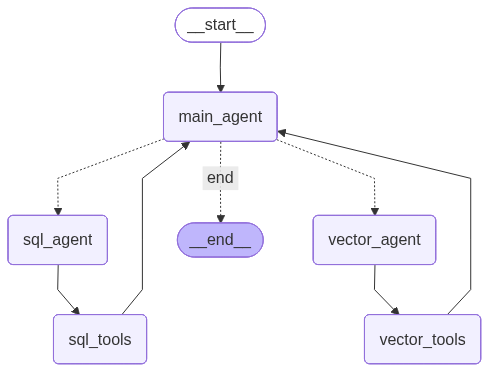

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))
